# Lab | Introduction to LoRA Tuning using PEFT from Hugging Face
<!-- ### Fine-tune a Foundational Model effortlessly -->

**Note:** This is more or less the same notebook you saw in the previous lesson, but that is ok. This is an LLM fine-tuning lab. In class we used a set of datasets and models, and in the labs you are required to change the LLMs models and the datasets including the pre-processing pipelines. 


# LoRA Tuning

In this notebook you are being introduced to how to apply LoRA Tuning with the PEFT library to a pre-trained model.

For a complete list of Models compatible with PEFT refer to their [documentation](https://huggingface.co/docs/peft/main/en/index#supported-methods).

A short sample of models families available to be trained with PEFT are: Bloom, Llama, GPT-J, GPT-2, BERT... and more. Hugging Face is working hard to bring more Models to the Library.

## Brief introduction to LoRA Tuning.
LoRA is a re-parameterization technique. Its operation is simple, complex, and brilliant at the same time. It involves reducing the size of the matrices to be trained by dividing them in such a way that when multiplied, they yield the original matrix.

The weights that are modified are those of the reduced matrices, not the original matrix. It's better visualized in an image.

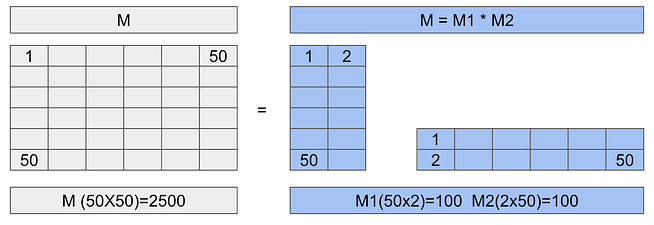

We have an original matrix of 50x50, which means we would have to modify about 2500 parameters. However, as we know, if we multiply two matrices of (2x50) and (50x2), we obtain a 50x50 matrix. Yet, these two matrices are formed by only 100 parameters each. In other words, for the reduced matrices, we need to modify a total of 200 parameters compared to the 2500 of the original matrix. This represents a 92% reduction, and the larger the original matrix, the greater the percentage of savings.

In Language Models like GPT-3 or any of the current ones with LoRA, it's possible that we only need to train about 0.02% of the original parameters. This varies for each model. The best part is that the obtained result is very similar to that of full fine-tuning, in some cases, it can even be better.

# Load the PEFT and Datasets Libraries.

The PEFT library contains the Hugging Face implementation of differente fine-tuning techniques, like LoRA Tuning.

Using the Datasets library we have acces to a huge amount of Datasets.

In [1]:
# !pip install -q peft==0.8.2
# !pip install -q datasets==2.16.1
#!pip install ipywidgets==7.7.5

From the transformers library we import the necesary classes to import the model and the tokenizer.

Then we can load the Tokenizer and the model.

Bloom is one of the smallest and smarter model available to be trained with PEFT Library using Prompt Tuning. You can use either of the models in the Bloom Family, I encorage you to use at least two of them and see the differences.

I'm using the smallest one just to spend less time trainig, and avoid memory problems in Colab.

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "bigscience/bloom-1b1"

tokenizer = AutoTokenizer.from_pretrained(model_name)
foundation_model = AutoModelForCausalLM.from_pretrained(model_name)

## Inference with the pre-trained model.
I'm going to do a test with the pre-trained model without fine-tuning, to see if something changes after the fine-tuning.

In [3]:
#this function returns the outputs from the model received, and inputs.
def get_outputs(model, inputs, max_new_tokens=100): #play with this function inputs and see if you get something interesting
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.5, #Avoid repetition.
        early_stopping=True, #The model can stop before reach the max_length
        eos_token_id=tokenizer.eos_token_id
    )
    return outputs

The dataset used for the fine-tuning contains prompts to be used with Large Language Models.

I'm going to request the pre-trained model that acts like a motivational coach.

In [4]:
#Inference original model
input_sentences = tokenizer("I have the possibility to acces a product that is awesome and anyone that tried wants to buy it. How should I approach shops to sell this product? ", return_tensors="pt")
foundational_outputs_sentence = get_outputs(foundation_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:418: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


["I have the possibility to acces a product that is awesome and anyone that tried wants to buy it. How should I approach shops to sell this product?  Is there any way of getting them into my shop? Thanks.\n\nA:\n\nYou can get your products in stock by selling on Amazon, but you will need some sort of marketing strategy.\nIf you're not sure how much money you'll make from these sales ("]


Not sure if the answer is correct or not, but for sure is not a prompt. We need to train our model if we want that acts like a prompt engineer.

# Preparing the Dataset.
The Dataset used is:

https://huggingface.co/datasets/fka/awesome-chatgpt-prompts

In [5]:
from datasets import load_dataset
dataset = "theoldmandthesea/17k_business_book"

#Create the Dataset to give business advice.
data = load_dataset(dataset)
data = data.map(lambda samples: tokenizer(samples["answer"]), batched=True)
train_sample = data["train"].select(range(50))

train_sample = train_sample.remove_columns("book")

display(train_sample)

Dataset({
    features: ['question', 'answer', 'input_ids', 'attention_mask'],
    num_rows: 50
})

In [6]:
print(train_sample[:1])

{'question': ['how might shared ownership models help retain talented employees?'], 'answer': ["Offering equity or profit sharing can incentivize top performers to stay long-term by giving them a stake in the company's success."], 'input_ids': [[216745, 386, 166695, 791, 36190, 65785, 1400, 191326, 2388, 7921, 8654, 525, 427, 27865, 74208, 1331, 34079, 4054, 267, 66414, 361, 368, 16333, 1256, 10859, 17]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


# Fine-Tuning.
First is necesary create a LoRA config.


In [7]:
# TARGET_MODULES
# https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220

import peft
from peft import LoraConfig, get_peft_model, PeftModel

lora_config = LoraConfig(#play with these config inputs
    r=16, #As bigger the R bigger the parameters to train.
    lora_alpha=32, # a scaling factor that adjusts the magnitude of the weight matrix. Usually set to 1
    target_modules=["query_key_value"], #You can obtain a list of target modules in the URL above.
    lora_dropout=0.05, #Helps to avoid Overfitting.
    bias="lora_only", # this specifies if the bias parameter should be trained.
    task_type="CAUSAL_LM"
)

The most important parameter is **r**, it defines how many parameters will be trained. As bigger the valuer more parameters are trained, but it means that the model will be able to learn more complicated relations between input and output.

Yo can find a list of the **target_modules** available on the [Hugging Face Documentation]( https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220)

**lora_dropout** is like the commom dropout is used to avoid overfitting.

**bias** I was hesitating if use *none* or *lora_only*. For text classification the most common value is none, and for chat or question answering, *all* or *lora_only*.

**task_type**. Indicates the task the model is beign trained for. In this case, text generation.

### Create the PEFT model.



In [8]:
peft_model = get_peft_model(foundation_model, lora_config)
print(peft_model.print_trainable_parameters())

trainable params: 2,469,888 || all params: 1,067,673,600 || trainable%: 0.23133362106171773
None


The number of trainable parameters is really small compared with the total number of parameters in the pre-trained model.

In [9]:
#Create a directory to contain the Model
import os
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")

In the TrainingArgs we inform the number of epochs we want to train, the output directory and the learning_rate.

In [10]:
#Creating the TrainingArgs
import transformers
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir=output_directory,
    auto_find_batch_size=True, # Find a correct bvatch size that fits the size of Data.
    learning_rate= 3e-2, # Higher learning rate than full fine-tuning.
    num_train_epochs=2,
    use_cpu=False
)

2024-10-09 17:24:11.819729: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-09 17:24:11.819794: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-09 17:24:11.821004: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-09 17:24:11.828087: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-09 17:24:12.843392: W tensorflow/compiler/tf2

Now we can train the model.
To train the model we need:


*   The PEFT Model.
*   The training_args
* The Dataset
* The result of DataCollator, the Dataset ready to be procesed in blocks.





In [11]:
#!pip install wandb --upgrade



In [12]:
#This cell may take up to 15 minutes to execute.
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_sample,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
trainer.train()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: salvacat (salvacat-). Use `wandb login --relogin` to force relogin


You're using a BloomTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss


TrainOutput(global_step=14, training_loss=16.333724975585938, metrics={'train_runtime': 5.6934, 'train_samples_per_second': 17.564, 'train_steps_per_second': 2.459, 'total_flos': 20052076584960.0, 'train_loss': 16.333724975585938, 'epoch': 2.0})

In [13]:
#Save the model.
peft_model_path = os.path.join(output_directory, f"lora_model")

trainer.model.save_pretrained(peft_model_path)

In [14]:
#Load the Model.
loaded_model = PeftModel.from_pretrained(foundation_model,
                                        peft_model_path,
                                        is_trainable=False)

## Inference the fine-tuned model.

In [15]:
# Step 1: Identify the model's device
device = next(loaded_model.parameters()).device

# Step 2: Tokenize the input and move it to the model's device
input_sentences = tokenizer(
    "I have the possibility to acces a product that is awesome and anyone that tried wants to buy it. How should I approach shops to sell this product? ",
    return_tensors="pt"
).to(device)  # Move inputs to the same device as the model

# Step 3: Run inference
foundational_outputs_sentence = get_outputs(
    loaded_model,
    input_sentences,
    max_new_tokens=50
)

# Step 4: Decode and print the output
print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:418: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


['I have the possibility to acces a product that is awesome and anyone that tried wants to buy it. How should I approach shops to sell this product?  What do they want? Is their strengths recognized, not what can be measured with success builds trust in each person’s unique abilities allows them time for growth helps build confidence sets goals beyond accomplishments encourages positive feedback provides opportunities leads questions about how we are doing']


The result is amazing. Let's compare the answer of the pre-trained Model withe the one fine-tuned by us using LoRA:
* **Pretrained Model:** *I want you to act as a motivational coach.*  Don't be afraid of being challenged.
* **Fine-Tuned Model:** I want you to act as a motivational coach.  I will provide some information about someone\'s motivation and goals, but it should be your job  in order my first request – "I need someone who can help me find the best way for myself stay motivated when competing against others." My suggestion is “I have

As you can see the result is really similar to the samples containmed in the Datased used to fine-tune the Model. And we only trained the Model for 10 epochs and with a really small number of rows.

In [16]:
!pip install panel


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

# Define the base model name from Hugging Face and the path to the LoRA adapter
base_model_name = "bigscience/bloom-1b1"  # Replace with the original base model name
peft_model_path = "/notebooks/peft_lab_outputs/lora_model"  # Replace with the path to your LoRA model

# Load tokenizer using the base model name
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

# Load the base model
base_model = AutoModelForCausalLM.from_pretrained(base_model_name)

# Load the LoRA adapter model
model = PeftModel.from_pretrained(base_model, peft_model_path)

# Move model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Rest of your code for inference and panel integration


In [17]:
!pip install pyngrok


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [18]:
from pyngrok import ngrok
public_url = ngrok.connect(8080)
print("Public URL:", public_url)


Public URL: NgrokTunnel: "https://18a0-172-83-13-4.ngrok-free.app" -> "http://localhost:8080"


In [19]:
import panel as pn
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

# Initialize Panel extension and set theme
pn.extension(sizing_mode="stretch_width")
pn.config.sizing_mode = "stretch_width"

# Create the chat interface components
chat_history = pn.widgets.TextAreaInput(
    value="",
    placeholder="Chatbot conversation will appear here...",
    disabled=True,
    height=400,
    sizing_mode="stretch_both"
)

user_input = pn.widgets.TextInput(
    name="User Input",
    placeholder="Type a message...",
    sizing_mode="stretch_width"
)

def generate_response(event):
    if not user_input.value.strip():  # Check if input is empty
        return
    
    user_message = user_input.value
    chat_history.value += f"You: {user_message}\n"
    
    # Tokenize input and generate response
    inputs = tokenizer(user_message, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.generate(
            inputs['input_ids'],
            max_length=150,
            pad_token_id=tokenizer.eos_token_id,
            temperature=0.7,
            top_p=0.9,
            do_sample=True
        )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    chat_history.value += f"Bot: {response}\n\n"
    
    # Clear user input after sending
    user_input.value = ""

send_button = pn.widgets.Button(name="Send", button_type="primary")
send_button.on_click(generate_response)

# Create input row with button
input_row = pn.Row(user_input, send_button, sizing_mode="stretch_width")

# Layout for the chatbot interface
layout = pn.Column(
    pn.pane.Markdown("# Simple Chatbot"),
    chat_history,
    input_row,
    sizing_mode="stretch_width"
)

# Serve the application
if __name__ == "__main__":
    layout.servable()
    pn.serve(layout, port=8080, show=True, address="0.0.0.0")

Launching server at http://0.0.0.0:8080


ERROR:bokeh.server.views.ws:Refusing websocket connection from Origin 'https://18a0-172-83-13-4.ngrok-free.app';                       use --allow-websocket-origin=18a0-172-83-13-4.ngrok-free.app or set BOKEH_ALLOW_WS_ORIGIN=18a0-172-83-13-4.ngrok-free.app to permit this; currently we allow origins {'localhost:8080'}
ERROR:bokeh.server.views.ws:Refusing websocket connection from Origin 'https://18a0-172-83-13-4.ngrok-free.app';                       use --allow-websocket-origin=18a0-172-83-13-4.ngrok-free.app or set BOKEH_ALLOW_WS_ORIGIN=18a0-172-83-13-4.ngrok-free.app to permit this; currently we allow origins {'localhost:8080'}
ERROR:bokeh.server.views.ws:Refusing websocket connection from Origin 'https://18a0-172-83-13-4.ngrok-free.app';                       use --allow-websocket-origin=18a0-172-83-13-4.ngrok-free.app or set BOKEH_ALLOW_WS_ORIGIN=18a0-172-83-13-4.ngrok-free.app to permit this; currently we allow origins {'localhost:8080'}


# Exercise

- Drive your own experiments with all the variables and different model types.
    - Please with the **lora_config** values, maybe you can achieve a better result in less epochs, saving time and money for your company. :-)
- Write a one page report
    - What did you learn?